In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/data.csv', on_bad_lines='skip').dropna()
data

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1
...,...,...
669635,10redtux10,1
669636,infrared1,1
669637,184520socram,1
669638,marken22a,1


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669639 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669639 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [20]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
strength,669639.0,0.990198,0.507947,0.0,1.0,1.0,1.0,2.0
password_len,669638.0,11.991646,2.819956,3.0,10.0,11.0,13.0,222.0


In [21]:
data.isnull().sum()

password        0
strength        0
password_len    1
dtype: int64

In [22]:
data.duplicated().sum()

0

[Text(0, 0, '89701'), Text(0, 0, '496801'), Text(0, 0, '83137')]

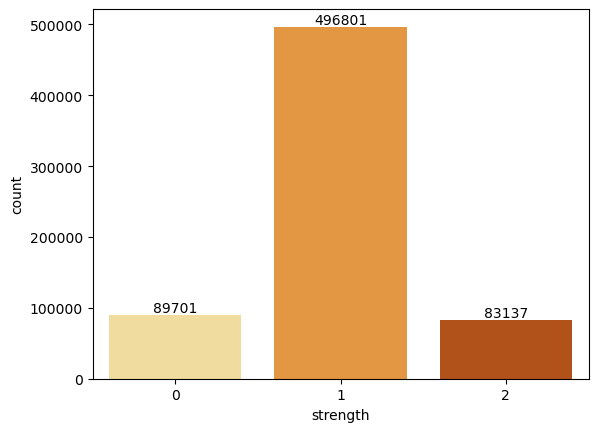

In [23]:
ax = sns.countplot(data=data, x=data['strength'], palette='YlOrBr')
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [5]:
data['strength'] = data['strength'].astype('int8')

In [11]:
data['text_to_letter'] = data['password'].apply(lambda x: ' '.join(list(x)))
data

C:\Users\indiz\AppData\Local\Temp\ipykernel_15072\3219363206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_to_letter'] = data['password'].apply(lambda x: ' '.join(list(x)))


,password,strength,password_len,text_to_letter
0,kzde5577,1,10.0,k z d e 5 5 7 7
1,kino3434,1,10.0,k i n o 3 4 3 4
2,visi7k1yr,1,11.0,v i s i 7 k 1 y r
3,megzy123,1,10.0,m e g z y 1 2 3
4,lamborghin1,1,13.0,l a m b o r g h i n 1
...,...,...,...,...
669634,sh4tup,0,12.0,s h 4 t u p
669635,10redtux10,1,11.0,1 0 r e d t u x 1 0
669636,infrared1,1,14.0,i n f r a r e d 1
669637,184520socram,1,11.0,1 8 4 5 2 0 s o c r a m


### 3.3. EDA

C:\Users\indiz\AppData\Local\Temp\ipykernel_15072\735982834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['password_len'] = pd.DataFrame(password_len)


,password,strength,password_len,text_to_letter
0,kzde5577,1,10.0,k z d e 5 5 7 7
1,kino3434,1,10.0,k i n o 3 4 3 4
2,visi7k1yr,1,11.0,v i s i 7 k 1 y r
3,megzy123,1,10.0,m e g z y 1 2 3
4,lamborghin1,1,13.0,l a m b o r g h i n 1
...,...,...,...,...
579273,hm1qazxsw2,1,11.0,h m 1 q a z x s w 2
579274,p09876543p,1,14.0,p 0 9 8 7 6 5 4 3 p
579275,z1a9i9d4,1,11.0,z 1 a 9 i 9 d 4
579276,owexuv946,1,12.0,o w e x u v 9 4 6


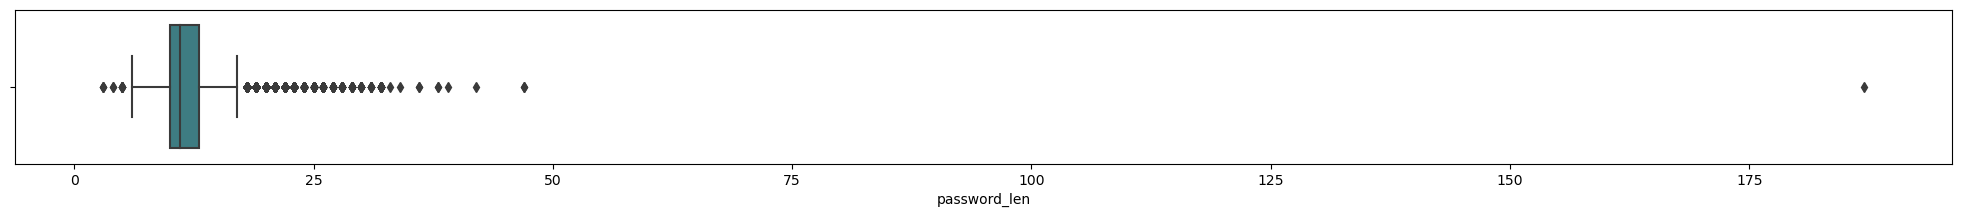

In [13]:
password_len = [len(word) for word in data['password'].str.split('')]
data['password_len'] = pd.DataFrame(password_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['password_len'], palette="crest")

data = data.dropna()
data

In [14]:
Q1 = data['password_len'].quantile(0.01)
Q3 = data['password_len'].quantile(0.99)

print(Q1)
print(Q3)

8.0
18.0


8.0
18.0


<Axes: xlabel='password_len'>

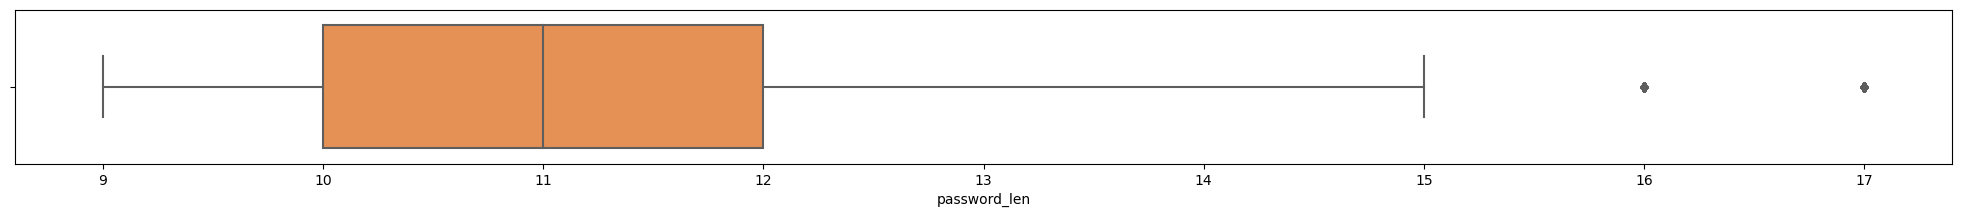

In [15]:
Q1 = data['password_len'].quantile(0.01)
Q3 = data['password_len'].quantile(0.99)

print(Q1)
print(Q3)

data = data[(data['password_len'] > Q1) & (data['password_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['password_len'], palette="Oranges")

# 4. Classification Algorithms

In [100]:
X = data["text_to_letter"]
Y = data["strength"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
# print(X_val.shape)

(437198,)
(123313,)
(62279,)


In [101]:
vocab_size = 125
embedding_dim = 100
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [102]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
# validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
# validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

# validating_padded = np.array(validating_padded)
# validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
# validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# training_label = to_categorical(training_label)
# testing_label = to_categorical(testing_label)
# validating_label = to_categorical(validating_label)


117


In [104]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTress', extraTrees),
    # ('gradient', gradient),
    # ('randomforest', randomForest),
    # ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    # ('knn', knn),
    # ('decisionTree', decisionTree),

], n_jobs=-1)

In [105]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [106]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 99.71 %
Test Score         : 98.27 %
R Squared Error    : 0.97
Mean Squared Error : 0.02


In [109]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  0        0     0
1                  0        0     0
2                  0        0     0
3                  0        0     0
4                  0        0     0
664 / 38292


In [110]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12807
           1       0.98      0.96      0.97     13020
           2       0.96      0.99      0.98     12465

    accuracy                           0.98     38292
   macro avg       0.98      0.98      0.98     38292
weighted avg       0.98      0.98      0.98     38292



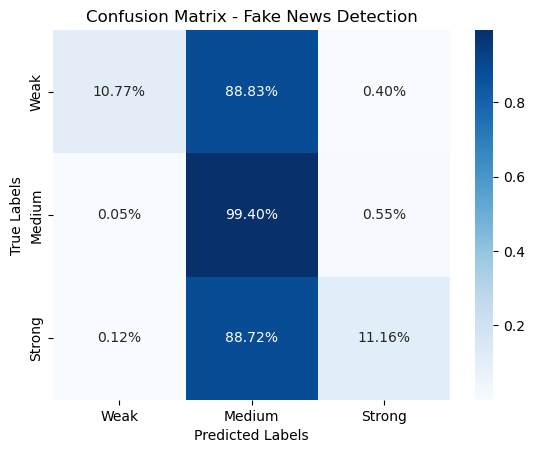

In [28]:
labels = ['Weak', 'Medium', 'Strong']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 5. Neural Network

In [16]:
X = data["text_to_letter"]
Y = data["strength"]

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(334472,)
(94339,)
(47646,)


In [17]:
vocab_size = 125
embedding_dim = 100
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

training_label = to_categorical(training_label)
testing_label = to_categorical(testing_label)
validating_label = to_categorical(validating_label)


104


In [19]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.4))
    model.add(ReLU())
    model.add(MaxPooling1D())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()



model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.00001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           12500     
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 1024)              2049024   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,324,695
Trainable params: 2,324,695
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epoch = 10
batch_size = 64

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/10
1550/1550 [==============================] - 7s 4ms/step - loss: 0.2690 - accuracy: 0.9574 - val_loss: 0.0570 - val_accuracy: 0.9806
Epoch 2/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0520 - accuracy: 0.9821 - val_loss: 0.0484 - val_accuracy: 0.9814
Epoch 3/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0478 - accuracy: 0.9830 - val_loss: 0.0468 - val_accuracy: 0.9813
Epoch 4/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0460 - accuracy: 0.9836 - val_loss: 0.0459 - val_accuracy: 0.9828
Epoch 5/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0448 - accuracy: 0.9843 - val_loss: 0.0464 - val_accuracy: 0.9816
Epoch 6/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0440 - accuracy: 0.9846 - val_loss: 0.0455 - val_accuracy: 0.9816
Epoch 7/10
1550/1550 [==============================] - 6s 4ms/step - loss: 0.0434 - accuracy: 0.9847 - val_loss: 0.0458 - val_accuracy:

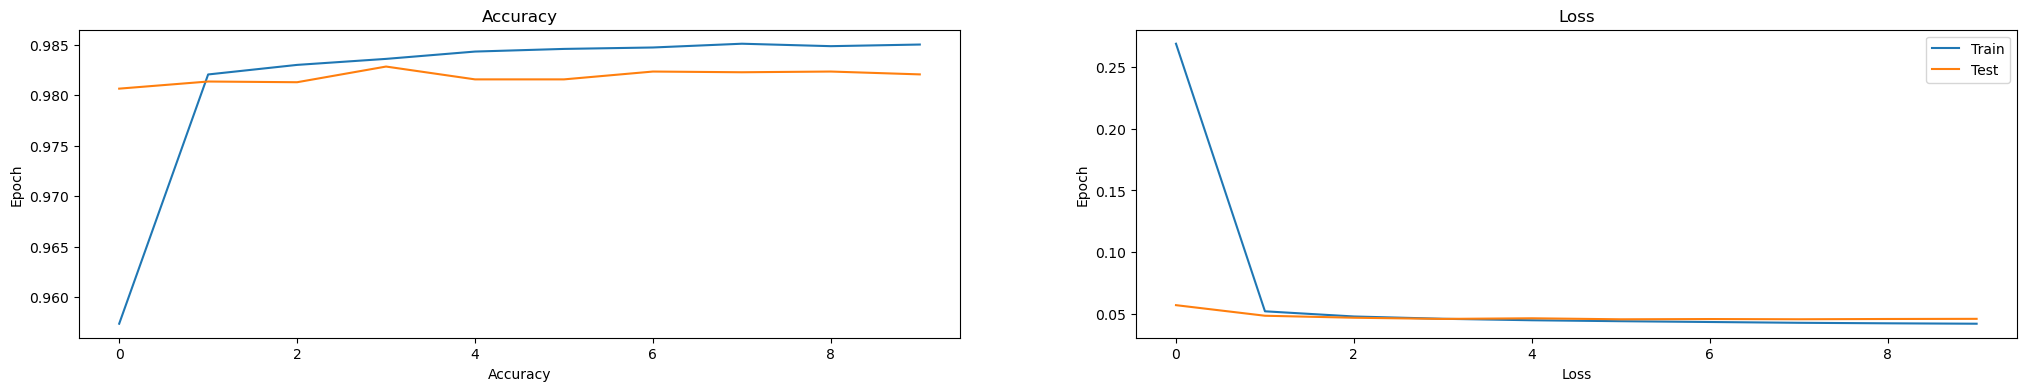

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [37]:
train_predictions = model.predict(testing_padded).argmax(axis=1)

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

864/864 [==============================] - 1s 1ms/step
   Train Predictions  Actuals  Diff
0                  0        0     0
1                  0        0     0
2                  0        0     0
3                  0        0     0
4                  0        0     0
461 / 27648


In [38]:
y_pred = np.rint(model.predict(testing_padded, verbose=0))

print(classification_report(testing_label,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9216
           1       0.97      0.99      0.98      9216
           2       0.99      0.96      0.98      9216

   micro avg       0.98      0.98      0.98     27648
   macro avg       0.98      0.98      0.98     27648
weighted avg       0.98      0.98      0.98     27648
 samples avg       0.98      0.98      0.98     27648



864/864 [==============================] - 1s 1ms/step


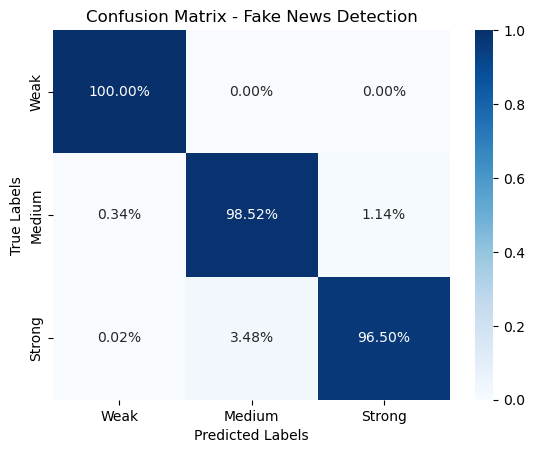

In [39]:
labels = ['Weak', 'Medium', 'Strong']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()